In [1]:
!pip -qq install -U langchain langchain-community langgraph pydantic google-ai-generativelanguage==0.6.15 langchain-google-genai

In [2]:
!pip install "pydantic>=2.8,<3.0"
!pip install "langchain-core>=0.3.10"
!pip install "langgraph>=1.0.0"
!pip install "langchain-google-genai>=2.0.0"
!pip install "google-genai>=1.50.0"
!pip install reflex
!pip install pyttsx3 gTTS soundfile pydub SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 2.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: click
    Found existing installation: click 8.1.8
    Uninstalling click-8.1.8:
      Successfully uninstalled click-8.1.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gtts 2.5.4 requires click<8.2,>=7.1, but you have click 8.3.1 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
  Attempting uninstall: 

In [3]:
import os
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.types import Command

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chat_models import init_chat_model
from langchain_core.messages import AnyMessage, HumanMessage

from google.colab import userdata

from getpass import getpass
import os

# Enter the key securely (won't be visible when typed)
os.environ['API_KEY'] = getpass('Enter your API key: ')

# Use the key
GOOGLE_API_KEY = os.environ['API_KEY']


Enter your API key:  ········


In [4]:
# Define LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
    system_instruction="""You are an expert technical writer. Always give clear,
     concise, and straight-to-the-point answers."""
)

# Define the graph state
class State(dict):
    text: str
    topics: str
    title :str
    best_title: str
    blog_markdown: str

# Define nodes (steps)
def extract_topics(state: State) -> State:
    prompt = f"Extract 1-3 key topics from the following text:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    state["topics"] = resp.content.strip()
    return state

def generate_title(state: State) -> State:
    prompt = f"Generate two catchy blog titles for each one these topics:\n\n{state['topics']}"
    resp = llm.invoke(prompt)
    state["title"] = resp.content.strip()
    return state

# --- New nodes to add (keep style & formatting of original code) ---
def choose_title(state: State) -> State:
    """
    Choose the best title from `state['title']` (which contains generated title options).
    Strategy: ask LLM to rank and return the single best title.
    """
    prompt = (
        "From the following candidate titles (pick exactly one best title). "
        "Return only the chosen title on a single line.\n\n"
        f"{state['title']}"
    )
    resp = llm.invoke(prompt)
    # ensure single-line title
    best = resp.content.strip().splitlines()[0].strip()
    state["best_title"] = best
    return state

def write_blog(state: State) -> State:
    """
    Generate the blog body using the chosen title `state['best_title']` and the original input text.
    Produce markdown output suitable for platform-specific templates (we'll post-format later).
    """
    prompt = (
        f"Write a concise but thorough blog post in markdown using the title below. "
        f"Use ~6–10 short paragraphs, include 2-3 subheadings, and a short 2-line conclusion.\n\n"
        f"Title: {state['best_title']}\n\n"
        f"Source/context text:\n{state['text']}\n\n"
        "Return the blog in markdown only (no commentary)."
    )
    resp = llm.invoke(prompt)
    state["blog_markdown"] = resp.content.strip()
    return state

# Build the graph
workflow = StateGraph(State)
workflow.add_node("extract_topics", extract_topics)
workflow.add_node("generate_title", generate_title)
workflow.add_node("choose_title", choose_title)
workflow.add_node("write_blog", write_blog)

# Flow: extract_topics → generate_title → END
workflow.set_entry_point("extract_topics")
workflow.add_edge("extract_topics", "generate_title")
workflow.add_edge("generate_title", "choose_title")
workflow.add_edge("choose_title", "write_blog")
workflow.add_edge("write_blog", END)


# Compile runnable graph
graph = workflow.compile()

In [5]:
PLATFORM_TEMPLATES = {
    "linkedin": {
        "excerpt_chars": 400,
        "add_cta": True,
        "include_hashtags": True,
        "hashtags": ["#AI", "#RAG", "#LlamaIndex"]
    },
    "substack": {
        "excerpt_chars": 800,
        "add_cta": False,
        "include_hashtags": False
    },
    "medium": {
        "excerpt_chars": 500,
        "add_cta": True,
        "include_hashtags": False
    },
    "instagram": {
        "excerpt_chars": 2200,  # caption limit ~2200 chars
        "add_cta": True,
        "include_hashtags": True,
        "visual_hint": True
    }
}

def render_for_platform(markdown_text: str, platform: str):
    """
    Convert base markdown blog into platform-specific formats.
    Output: dict with {'content': rendered_text}
    """
    platform = platform.lower()

    if platform == "linkedin":
        # LinkedIn supports minimal markdown → convert to rich-text-ish formatting
        rendered = markdown_text.replace("##", "###").replace("###", "####")
        rendered = rendered.replace("**", "")  # LinkedIn strips bold markers
        return {"content": rendered}

    elif platform == "medium":
        # Medium accepts full markdown
        return {"content": markdown_text}

    elif platform == "substack":
        # Substack supports HTML-rich markdown
        rendered = markdown_text + "\n\n---\n*Written via AI Blog Generator*"
        return {"content": rendered}

    elif platform == "instagram":
        # Instagram ≠ markdown → break blog into punchy carousel captions
        lines = markdown_text.split("\n")
        captions = [l[:1900] for l in lines if l.strip()]
        return {"content": "\n\n".join(captions)}

    else:
        return {"content": markdown_text}



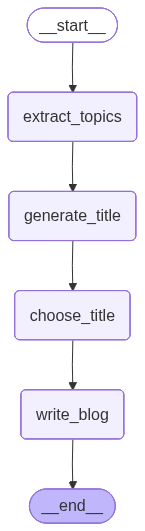

In [6]:
graph

In [7]:
input_text = (
    "LlamaIndex agents are AI-powered reasoning and decision engines designed to automate complex tasks, "
    "especially those involving private or domain-specific data. "
    "LlamaIndex is highly regarded for its data-centric approach and strong Retrieval-Augmented Generation (RAG) features "
    "when compared to frameworks like LangChain or CrewAI."
)

result = graph.invoke({"text": input_text})

print("Topics:", result["topics"])
print("\n"+"="*50+"\n")

print("Titles:", result["title"])
print("\n"+"="*50+"\n")

print("Best Title:", result["best_title"])
print("\n"+"="*50+"\n")

print(result["blog_markdown"])


Topics: Here are 3 key topics extracted from the text:

1.  **LlamaIndex Agents:** Focuses on the core subject of the text - the agents themselves and their purpose (reasoning and decision-making).
2.  **Automation of Complex Tasks:** Highlights the primary function and benefit of using LlamaIndex agents.
3.  **Data-Centric RAG:** Emphasizes LlamaIndex's strengths, particularly its focus on data and its strong Retrieval-Augmented Generation capabilities.


Titles: Okay, here are two catchy blog titles for each of the provided topics:

**1. LlamaIndex Agents:**

*   **Title 1: Unleash Your Data's Potential: Meet the LlamaIndex Agents** (Focuses on the benefit and introduces the agents)
*   **Title 2: Beyond Chatbots: How LlamaIndex Agents are Revolutionizing AI Decision-Making** (Implies advanced capabilities and innovation)

**2. Automation of Complex Tasks:**

*   **Title 1: From Mundane to Magnificent: Automating Complex Tasks with LlamaIndex** (Highlights the transformation and the 

In [8]:
md = result["blog_markdown"]
linkedin_post = render_for_platform(md, "linkedin")["content"]

In [9]:
linkedin_post

'```markdown\n# Supercharge Your RAG: The LlamaIndex Guide to Data-Powered Generation\n\nIn the ever-evolving landscape of AI, Retrieval-Augmented Generation (RAG) is emerging as a powerful paradigm for building intelligent applications. RAG combines the strengths of pre-trained language models with the ability to retrieve and incorporate information from external knowledge sources, leading to more accurate, relevant, and context-aware responses.\n\nLlamaIndex stands out as a leading framework for building RAG applications, especially when dealing with private or domain-specific data. It provides a comprehensive set of tools and abstractions that simplify the process of indexing, querying, and integrating your data with large language models (LLMs). Unlike some other frameworks, LlamaIndex prioritizes a data-centric approach, making it easier to manage and leverage your unique datasets.\n\n#### Why Choose LlamaIndex for RAG?\n\nLlamaIndex offers several key advantages for building robu

In [10]:
pip install PyAudio


  Using cached PyAudio-0.2.14.tar.gz (47 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for PyAudio (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for PyAudio
Failed to build PyAudio
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (PyAudio)
Note: you may need to restart the kernel to use updated packages.


In [13]:
import speech_recognition as sr

def record_voice_input():
    recognizer = sr.Recognizer()
    with sr.Microphone() as mic:
        print("🎤 Speak now...")
        audio = recognizer.listen(mic)

    try:
        text = recognizer.recognize_google(audio)
        print("Voice Input:", text)
        return text
    except:
        print("Error: Could not understand audio")
        return ""


In [20]:
!pip install openai-whisper
import whisper

# Full path to the audio file
audio_path = "/kaggle/input/myvoice/New recording 7.m4a"

# Load Whisper model
model = whisper.load_model("base")

# Transcribe audio
result = model.transcribe(audio_path)

# Print transcription
print("🎤 Transcription:", result["text"])

print("🎤 Transcribed:", input_text)


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🎤 Transcription:  generate block following cream on topic agent quilting
🎤 Transcribed: LlamaIndex agents are AI-powered reasoning and decision engines designed to automate complex tasks, especially those involving private or domain-specific data. LlamaIndex is highly regarded for its data-centric approach and strong Retrieval-Augmented Generation (RAG) features when compared to frameworks like LangChain or CrewAI.


In [22]:
result = graph.invoke({"text": input_text})

print("🔹 Topics:", result["topics"])
print("🔹 Titles:", result["title"])
print("\n----- BLOG OUTPUT -----\n")
print(result["blog_markdown"])


🔹 Topics: Here are 3 key topics extracted from the text:

1.  **LlamaIndex Agents:** Focuses on their purpose as AI reasoning and decision engines.
2.  **Automation of Complex Tasks:** Highlights the primary function of these agents.
3.  **Data-Centric RAG Capabilities:** Emphasizes LlamaIndex's strength in handling data retrieval and generation, especially in private or domain-specific contexts.
🔹 Titles: Okay, here are two catchy blog titles for each of the 3 key topics you provided:

**1. LlamaIndex Agents: Focuses on their purpose as AI reasoning and decision engines.**

*   **Title 1:** LlamaIndex Agents: Your AI Brain for Complex Decisions
*   **Title 2:** Unleash AI Reasoning: How LlamaIndex Agents Think and Act

**2. Automation of Complex Tasks: Highlights the primary function of these agents.**

*   **Title 1:** Ditch the Drudgery: LlamaIndex Agents Automate Your Toughest Tasks
*   **Title 2:** AI on Autopilot: Simplifying Complex Workflows with LlamaIndex Agents

**3. Data-Ce

In [23]:
from gtts import gTTS

def blog_to_audio(markdown_text, filename="blog_audio.mp3"):
    tts = gTTS(markdown_text)
    tts.save(filename)
    return filename


In [24]:
audio_file = blog_to_audio(result["blog_markdown"])
audio_file


'blog_audio.mp3'

In [25]:
out = graph.invoke({"text": input_text})
md = out["blog_markdown"]

linkedin_post = render_for_platform(md, "linkedin")["content"]
medium_post = render_for_platform(md, "medium")["content"]
substack_post = render_for_platform(md, "substack")["content"]
instagram_post = render_for_platform(md, "instagram")["content"]

# print results
print("---- RAW MARKDOWN ----")
print(md)
print("\n\n---- LINKEDIN VERSION ----")
print(linkedin_post)
print("\n\n---- MEDIUM VERSION ----")
print(medium_post)
print("\n\n---- SUBSTACK VERSION ----")
print(substack_post)
print("\n\n---- INSTAGRAM VERSION ----")
print(instagram_post)


---- RAW MARKDOWN ----
```markdown
# Beyond Chatbots: LlamaIndex Agents and the Future of Intelligent AI

We're rapidly moving beyond the era of simple chatbots. The future of AI lies in intelligent agents capable of reasoning, decision-making, and automating complex tasks. LlamaIndex is emerging as a powerful framework for building these advanced AI agents, particularly when dealing with private or domain-specific knowledge.

LlamaIndex agents are essentially AI-powered engines that can analyze information, strategize, and execute actions to achieve specific goals. They leverage large language models (LLMs) but go far beyond basic question answering. Think of them as digital assistants capable of handling multifaceted projects, from research and analysis to content creation and data management.

## LlamaIndex's Data-Centric Advantage

What sets LlamaIndex apart from other agent-building frameworks? Its core strength lies in its data-centric approach. LlamaIndex excels at integrating a